In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import locale
locale.setlocale(locale.LC_TIME, 'pt_BR.utf8')

'pt_BR.utf8'

In [2]:
def create_graph_line(series, title, x_label, y_label):
    plt.figure(figsize=(12,6))
    series.plot()
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid()
    plt.show()

# Carregar Dados

In [3]:
dias_semana = {
    'Monday': '1-segunda-feira',
    'Tuesday': '2-terça-feira',
    'Wednesday': '3-quarta-feira',
    'Thursday': '4-quinta-feira',
    'Friday': '5-sexta-feira',
    'Saturday': '6-sábado',
    'Sunday': '7-domingo'
}



In [4]:
df_rupturas = pd.read_csv('../data/processed/dados_ruptura.csv')
df_rupturas['dt_estoque'] = pd.to_datetime(df_rupturas['dt_estoque'])
# df_rupturas['dia_semana_en'] = df_rupturas['dt_estoque'].dt.day_name()
# df_rupturas['ano_mes'] = df_rupturas['dt_estoque'].dt.strftime('%Y-%m')
# df_rupturas['dia_semana_pt'] = df_rupturas['dia_semana_en'].map(dias_semana)
df_rupturas['is_ruptura'] = df_rupturas['is_ruptura'].apply(int)
df_rupturas.head()

,key_loja,cod_produto,dt_estoque,primeira_data,qt_estoque,is_ruptura
0,1,1428,2024-01-01,2024-01-01,108.0,0
1,1,1428,2024-01-02,2024-01-01,108.0,0
2,1,1428,2024-01-03,2024-01-01,108.0,0
3,1,1428,2024-01-04,2024-01-01,108.0,0
4,1,1428,2024-01-05,2024-01-01,108.0,0


In [5]:
df_similares = pd.read_csv('../data/raw/tb_similares.csv')
df_similares.rename(columns={"cod_material": "cod_produto"}, inplace=True)
df_similares.head()

,cod_produto,cod_material_recom,ranking
0,48635,25472,1
1,50651,74932,1
2,48062,77684,1
3,49893,48730,1
4,49943,84203,1


In [6]:
df_estoque = pd.read_csv('../data/raw/tb_estoques.csv')
df_estoque['dt_estoque'] = pd.to_datetime(df_estoque['dt_estoque'])
df_estoque.head()

,key_loja,cod_produto,dt_estoque,qt_estoque
0,1,1428,2024-03-18,108
1,1,1428,2024-12-13,24
2,1,1428,2024-07-30,33
3,1,1428,2024-07-22,34
4,1,1428,2024-07-29,34


In [33]:
df_vendas = pd.read_csv('../data/raw/tb_vendas.csv')
df_vendas.head()

,dt_venda,cod_pedido,canal,des_estado_franquia,key_loja,cod_material,categoria_produto,sub_categoria_produto,linha_produto,vlr_venda_tabelado,vlr_desconto
0,2024-05-10,386761455,FISCO,SP,1,1428,217.0,422944,731659,248.7,0.00
1,2024-03-25,377623716,DIGITAL,SP,1,1428,217.0,422944,731659,248.7,88.23
2,2024-03-19,376372149,DIGITAL,SP,1,1428,217.0,422944,731659,248.7,88.23
3,2024-10-23,414882456,DIGITAL,SP,1,1428,217.0,422944,731659,248.7,0.00
4,2024-02-27,371457908,DIGITAL,SP,1,1428,217.0,422944,731659,230.7,0.00


# Para cada ruptura, verificar se há similares recomendados com estoque > 0 na mesma loja/data

In [7]:
# 1. Juntar ruptura com similares recomendados
df_rupturas_similares = df_rupturas.merge(
    df_similares,
    on='cod_produto',  # SKU em ruptura
    how='left'
)


In [8]:
df_estoque_similares = df_estoque.rename(columns={'cod_produto': 'cod_material_recom'})
df_rupturas_similares_estoque = df_rupturas_similares.merge(df_estoque_similares, on=['cod_material_recom', 'key_loja', 'dt_estoque'], how='left', suffixes=('', '_similar'))
df_rupturas_similares_estoque['similar_disponivel'] = df_rupturas_similares_estoque['qt_estoque_similar'].fillna(0) > 0
df_rupturas_similares_estoque['similar_disponivel'] = df_rupturas_similares_estoque['similar_disponivel'].apply(int)
df_rupturas_similares_estoque.head()

,key_loja,cod_produto,dt_estoque,primeira_data,qt_estoque,is_ruptura,cod_material_recom,ranking,qt_estoque_similar,similar_disponivel
0,1,1428,2024-01-01,2024-01-01,108.0,0,1650.0,1.0,102.0,1
1,1,1428,2024-01-01,2024-01-01,108.0,0,1640.0,2.0,83.0,1
2,1,1428,2024-01-01,2024-01-01,108.0,0,48282.0,3.0,335.0,1
3,1,1428,2024-01-02,2024-01-01,108.0,0,1650.0,1.0,102.0,1
4,1,1428,2024-01-02,2024-01-01,108.0,0,1640.0,2.0,83.0,1


In [9]:
cobertura = (
    df_rupturas_similares_estoque[df_rupturas_similares_estoque['similar_disponivel']==1]
    .groupby('ranking')['cod_produto']
    .nunique()
    .reset_index(name='qtd_rupturas_com_similar')
)

cobertura['perc_total_rupturas'] = 100 * cobertura['qtd_rupturas_com_similar'] / df_rupturas['cod_produto'].nunique()
print(cobertura)

   ranking  qtd_rupturas_com_similar  perc_total_rupturas
0      1.0                        35            33.653846
1      2.0                        31            29.807692
2      3.0                        23            22.115385


In [10]:
total_rupturas = len(df_rupturas)
rupturas_com_similar = df_rupturas_similares_estoque['similar_disponivel'].any()
rupturas_com_similar
# print(f"Total de rupturas: {total_rupturas}")
# print(f"Rupturas com pelo menos 1 similar disponível: {rupturas_com_similar.sum()}")

np.True_

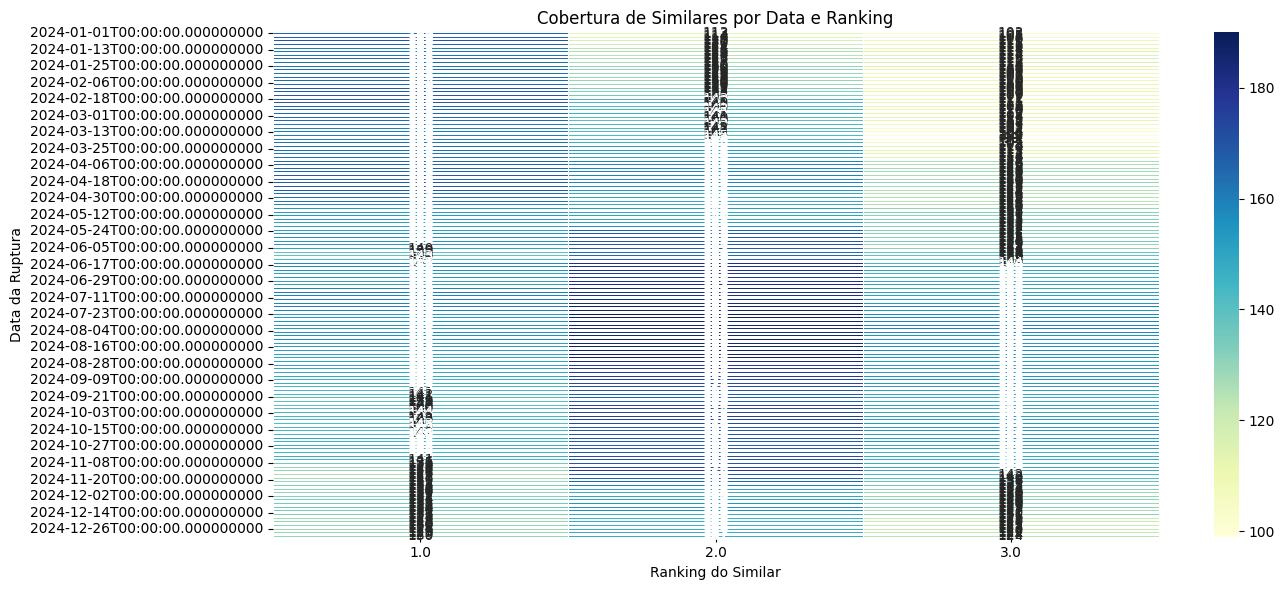

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Agrupar: contar quantas rupturas tiveram similar disponível por data e ranking
heatmap_data = (
    df_rupturas_similares_estoque[df_rupturas_similares_estoque['similar_disponivel']==1]
    .groupby(['dt_estoque', 'ranking'])
    .size()
    .unstack(fill_value=0)
)

# Reordenar por data
heatmap_data = heatmap_data.sort_index()

# Plotar heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt='d', linewidths=0.5)
plt.title('Cobertura de Similares por Data e Ranking')
plt.xlabel('Ranking do Similar')
plt.ylabel('Data da Ruptura')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

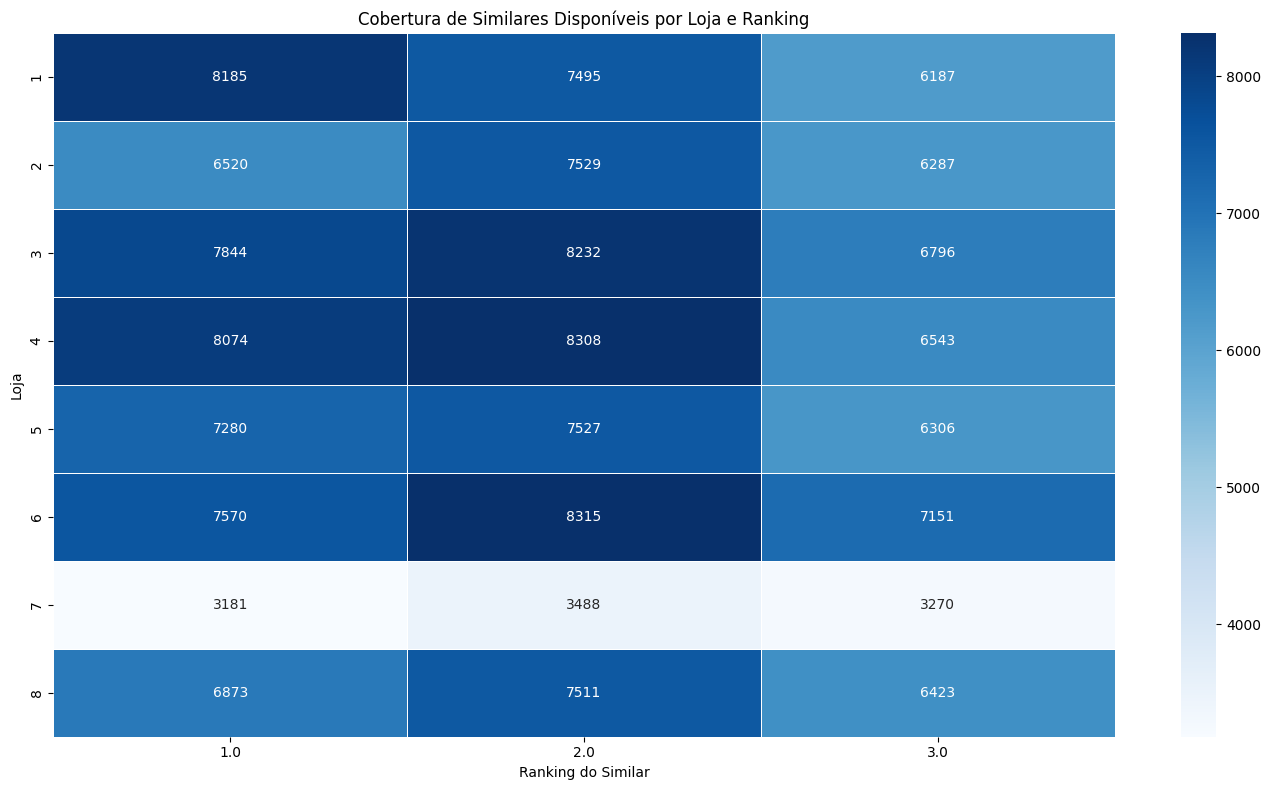

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Agrupar: contar quantas rupturas tiveram similar disponível por loja e ranking
heatmap_loja = (
    df_rupturas_similares_estoque[df_rupturas_similares_estoque['similar_disponivel']==1]
    .groupby(['key_loja', 'ranking'])
    .size()
    .unstack(fill_value=0)
)

# Reordenar lojas alfabeticamente
heatmap_loja = heatmap_loja.sort_index()

# Plotar o heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_loja, cmap='Blues', annot=True, fmt='d', linewidths=0.5)
plt.title('Cobertura de Similares Disponíveis por Loja e Ranking')
plt.xlabel('Ranking do Similar')
plt.ylabel('Loja')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

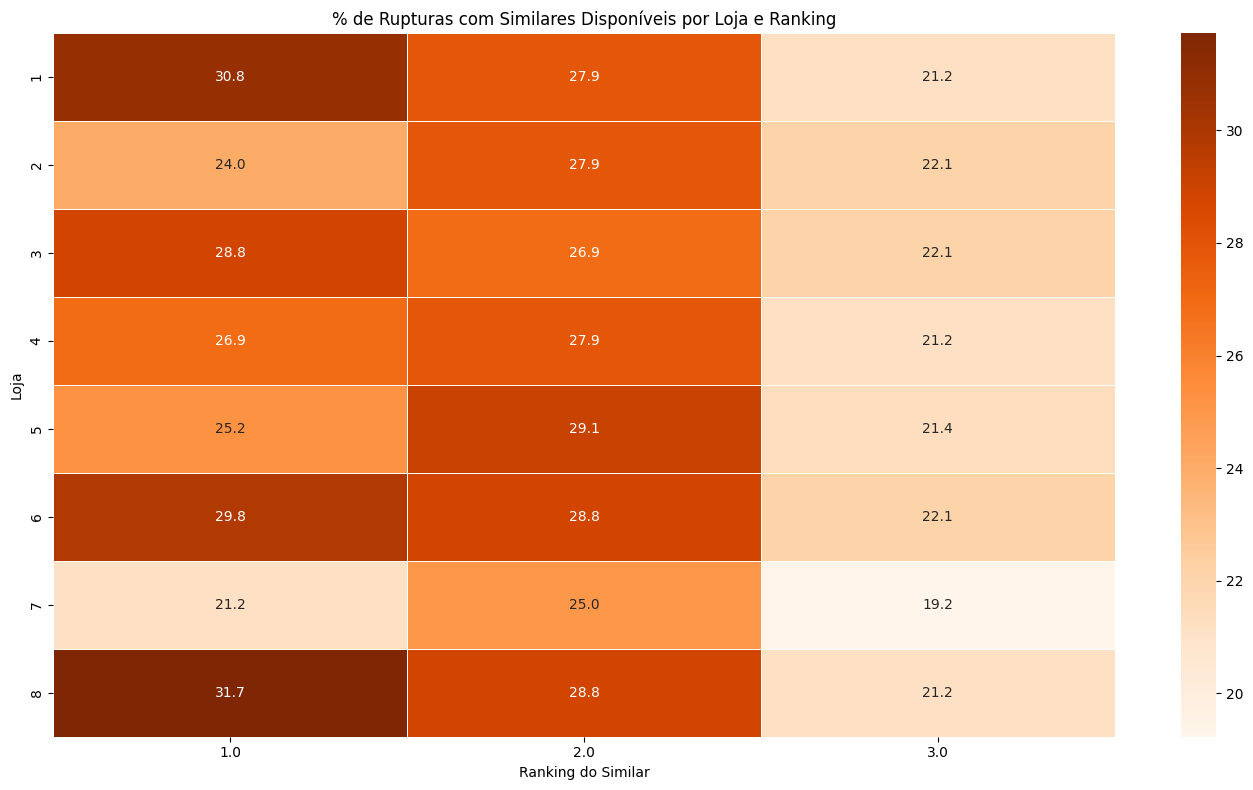

In [16]:
# Total de rupturas por loja
total_rupturas_por_loja = df_rupturas_similares_estoque.groupby('key_loja')['cod_produto'].nunique()

# Número de rupturas com similar disponível por loja e ranking
heatmap_loja_pct = (
    df_rupturas_similares_estoque[df_rupturas_similares_estoque['similar_disponivel']==1]
    .groupby(['key_loja', 'ranking'])['cod_produto']
    .nunique()
    .unstack(fill_value=0)
)

# Dividir para virar percentual
heatmap_loja_pct = heatmap_loja_pct.divide(total_rupturas_por_loja, axis=0) * 100

# Plotar
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_loja_pct, cmap='Oranges', annot=True, fmt=".1f", linewidths=0.5)
plt.title('% de Rupturas com Similares Disponíveis por Loja e Ranking')
plt.xlabel('Ranking do Similar')
plt.ylabel('Loja')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
total_rupturas = df_rupturas['is_ruptura'].sum()
proporcao = np.round((total_rupturas/df_rupturas.shape[0])*100, 2)
print(f"Total de eventos de ruptura: {total_rupturas} ({proporcao}% dos registros de estoque)")

In [ ]:
rupturas_por_loja = df_rupturas[df_rupturas['is_ruptura']==1].groupby('key_loja').size().sort_values(ascending=False)

plt.figure(figsize=(12,6))
rupturas_por_loja.head(20).plot(kind='bar')
plt.title('Top 20 Lojas com mais Rupturas')
plt.xlabel('Loja')
plt.ylabel('Quantidade de Rupturas')
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [ ]:
lojas = df_rupturas['key_loja'].unique()

for lj in lojas:
    print(lj)
    rupturas_por_loja = df_rupturas[(df_rupturas['key_loja']==lj)&(df_rupturas['is_ruptura']==1)].groupby('dt_estoque').size()
    
    plt.figure(figsize=(12,6))
    rupturas_por_loja.plot()
    plt.title(f'Evolução das Rupturas ao Longo do Tempo Loja {lj}')
    plt.xlabel('Data')
    plt.ylabel('Quantidade de Rupturas')
    plt.grid()
    plt.show()

In [ ]:
- Loja 1 pode ter ocasionado o comportamento de subida de ruptura no começo de junho

In [ ]:
import matplotlib.pyplot as plt



In [ ]:
type(rupturas_por_loja)
df_rupturas_por_loja = rupturas_por_loja.to_frame()
df_rupturas_por_loja.reset_index(inplace=True)
df_rupturas_por_loja.rename(columns={"0": "qtd_rupturas"}, inplace=True)
df_rupturas_por_loja.to_csv('df_rupturas_por_loja.csv',index=False)

In [ ]:
rupturas_por_sku = df_rupturas[df_rupturas['is_ruptura']==1].groupby('cod_produto').size().sort_values(ascending=False)

plt.figure(figsize=(12,6))
rupturas_por_sku.head(20).plot(kind='bar')
plt.title('Top 20 SKUs com mais Rupturas')
plt.xlabel('SKU')
plt.ylabel('Quantidade de Rupturas')
plt.xticks(rotation=45)
plt.grid()
plt.show()

- Posso olhar a ruptura dos SKUS por essas categorias:
    - categoria_produto Código da categoria do produto
    - sub_categoria_produto Código da subcategoria do produto
    - linha_produto

In [ ]:
df_ruptura_similar = df_rupturas.merge(df_similares, on='cod_produto', how='left')
df_ruptura_similar.head()

In [ ]:
df_ruptura_similar

In [ ]:
df_ruptura_similar = df_ruptura_similar.merge(
    df_estoque,
    left_on=['cod_material_recom', 'key_loja', 'dt_estoque'],
    right_on=['cod_produto', 'key_loja', 'dt_estoque'],
    how='left',
    suffixes=('', '_similar')
)

# Filtrar se o similar tinha estoque disponível (> 0)
df_ruptura_similar['similar_disponivel'] = df_ruptura_similar['qt_estoque'] > 0
df_ruptura_similar

In [ ]:
df_agrupado = (
    df_ruptura_similar
    .groupby(['cod_produto', 'key_loja', 'dt_estoque'])['similar_disponivel']
    .max()
    .reset_index()
)

df_agrupado

In [ ]:
# Se pelo menos um similar estava disponível, max() será True
quantidade_rupturas_com_similar = df_agrupado['similar_disponivel'].sum()
quantidade_total_rupturas = df_agrupado.shape[0]

# Taxa de rupturas com similar disponível
taxa_similar_disponivel = quantidade_rupturas_com_similar / quantidade_total_rupturas
print(f"Taxa de rupturas com similar disponível: {taxa_similar_disponivel:.2%}")

Você pode testar se existe diferença na cobertura de similares entre lojas, entre categorias, etc.

Por exemplo, usar teste de proporções entre lojas grandes e pequenas.

#### Como calcular a cobertura de similares por ranking

In [ ]:
# Agora, calcular a cobertura por ranking
cobertura_por_ranking = (
    df_ruptura_similar
    .groupby('ranking')['similar_disponivel']
    .mean()
    .reset_index()
    .sort_values('ranking')
)

cobertura_por_ranking['similar_disponivel'] = cobertura_por_ranking['similar_disponivel'] * 100  # Converter para %

print(cobertura_por_ranking)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.bar(cobertura_por_ranking['ranking'], cobertura_por_ranking['similar_disponivel'])
plt.title('Cobertura de Similares por Ranking')
plt.xlabel('Ranking do Similar')
plt.ylabel('% de Rupturas com Similar Disponível')
plt.grid()
plt.show()

#### Cobertura Cumulativa por Ranking

In [ ]:
# Agora, para cada ruptura, identificar o primeiro ranking que cobre
def primeiro_ranking_cobertura(grupo):
    similares_disponiveis = grupo[grupo['similar_disponivel']]
    if not similares_disponiveis.empty:
        return similares_disponiveis.iloc[0]['ranking']
    else:
        return None

# Aplicar por ruptura
primeiro_cobertura = df_ruptura_similar.groupby(['cod_produto', 'key_loja', 'dt_estoque']).apply(primeiro_ranking_cobertura).reset_index(name='ranking_cobertura')
primeiro_cobertura

In [ ]:
cobertura_cumulativa = (
    primeiro_cobertura['ranking_cobertura']
    .value_counts(dropna=False)
    .reset_index()
    .rename(columns={'ranking_cobertura': 'ranking', 'count': 'quantidade'})
    # .sort_values('ranking')
)

cobertura_cumulativa

In [ ]:
df_ruptura_similar['ranking'].value_counts()

In [ ]:
# Calcular % relativo
total_rupturas = primeiro_cobertura.shape[0]
cobertura_cumulativa['percentual'] = cobertura_cumulativa['quantidade'] / total_rupturas * 100

print(cobertura_cumulativa)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(distribuicao_cobertura['ranking'], distribuicao_cobertura['cobertura_acumulada'], marker='o')
plt.title('Cobertura Cumulativa de Similares por Ranking')
plt.xlabel('Ranking do Similar que Cobre a Ruptura')
plt.ylabel('% Acumulado de Rupturas Cobertas')
plt.xticks(distribuicao_cobertura['ranking'])
plt.grid()
plt.show()

Identificar quais lojas mais sofreram rupturas sem similar disponível, para mostrar onde o sistema de similares falha mais e onde há mais oportunidade de melhoria.

In [44]:
# 1. Para cada ruptura, verificar se houve algum similar disponível
# Agrupar no nível da ruptura
agrupado_ruptura = (
    df_rupturas_similares_estoque
    .groupby(['cod_produto', 'key_loja', 'dt_estoque'])
    .agg(tem_similar_disponivel=('similar_disponivel', 'max'))  # se ao menos um similar estava disponível
    .reset_index()
)


# 2. Separar rupturas sem nenhum similar disponível
rupturas_sem_similar = agrupado_ruptura[agrupado_ruptura['tem_similar_disponivel']==0]

# 3. Contar rupturas sem similar por loja
rupturas_sem_similar_por_loja = (
    rupturas_sem_similar
    .groupby('key_loja')
    .size()
    .sort_values(ascending=False)
    .reset_index(name='qtd_rupturas_sem_similar')
)

rupturas_sem_similar_por_loja.sort_values(['qtd_rupturas_sem_similar'],ascending=False, inplace=True)
# rupturas_sem_similar_por_loja['key_loja'] = rupturas_sem_similar_por_loja['key_loja'].apply(str)
print(rupturas_sem_similar_por_loja)

   key_loja  qtd_rupturas_sem_similar
0         5                     25413
1         2                     25398
2         4                     25339
3         1                     25329
4         8                     25220
5         6                     25132
6         3                     25020
7         7                     15735


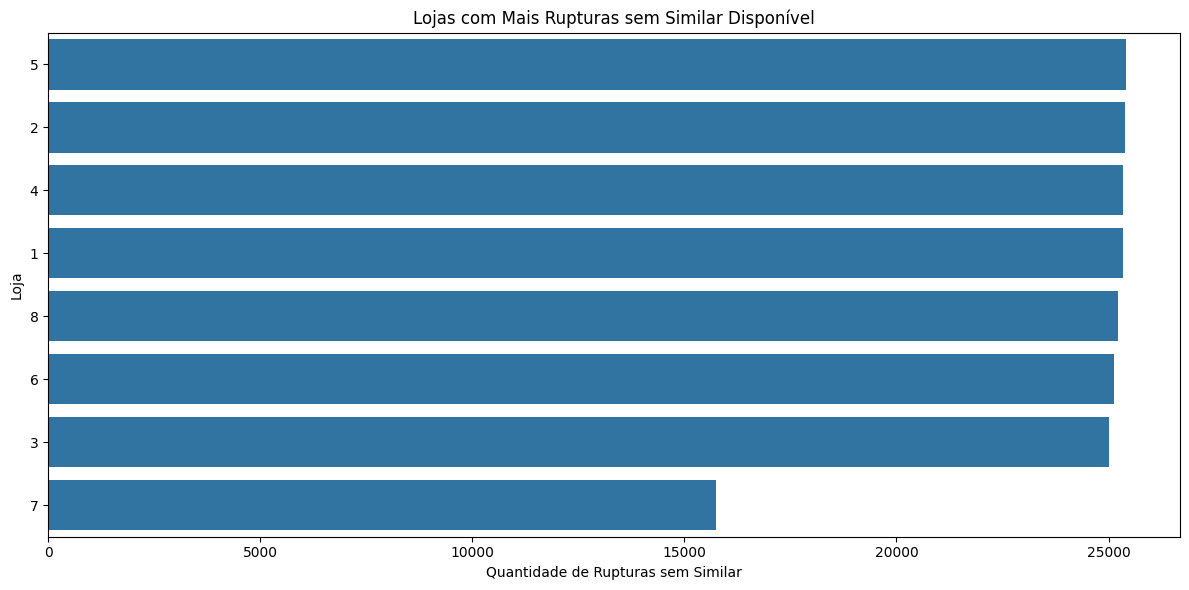

In [42]:
plt.figure(figsize=(12, 6))
sns.barplot(data=rupturas_sem_similar_por_loja, y='key_loja', x='qtd_rupturas_sem_similar', )
plt.title('Lojas com Mais Rupturas sem Similar Disponível')
plt.xlabel('Quantidade de Rupturas sem Similar')
plt.ylabel('Loja')
plt.tight_layout()
plt.show()

In [45]:
lojas_uf = df_vendas[['key_loja', 'des_estado_franquia']].drop_duplicates()

rupturas_sem_similar_uf = rupturas_sem_similar.merge(lojas_uf, on='key_loja', how='left')

# Contar rupturas sem similar por UF
rupturas_sem_similar_por_uf = (
    rupturas_sem_similar_uf
    .groupby('des_estado_franquia')
    .size()
    .sort_values(ascending=False)
    .reset_index(name='qtd_rupturas_sem_similar')
)

print(rupturas_sem_similar_por_uf)

  des_estado_franquia  qtd_rupturas_sem_similar
0                  SP                     66196
1                  SE                     25413
2                  AL                     25398
3                  PR                     25339
4                  MG                     25220
5                  GO                     25020


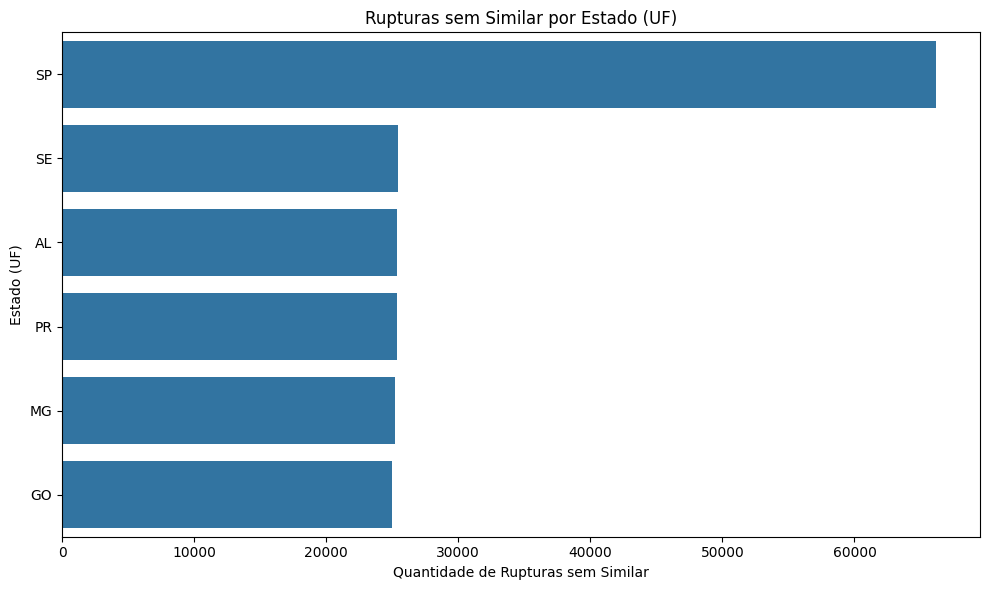

In [38]:
plt.figure(figsize=(10, 6))
sns.barplot(data=rupturas_sem_similar_por_uf, x='qtd_rupturas_sem_similar', y='des_estado_franquia')
plt.title('Rupturas sem Similar por Estado (UF)')
plt.xlabel('Quantidade de Rupturas sem Similar')
plt.ylabel('Estado (UF)')
plt.tight_layout()
plt.show()

In [49]:
# Total de rupturas por loja (com e sem similar)
total_rupturas_loja = agrupado_ruptura.groupby('key_loja').size().reset_index(name='total_rupturas')

# Unir com rupturas sem similar
rupturas_com_proporcao = rupturas_sem_similar_por_loja.merge(total_rupturas_loja, on='key_loja')

# Calcular percentual de rupturas sem similar
rupturas_com_proporcao['perc_sem_similar'] = 100 * rupturas_com_proporcao['qtd_rupturas_sem_similar'] / rupturas_com_proporcao['total_rupturas']
rupturas_com_proporcao['key_loja'] = rupturas_com_proporcao['key_loja'].apply(str)
print(rupturas_com_proporcao.sort_values('perc_sem_similar', ascending=False))

  key_loja  qtd_rupturas_sem_similar  total_rupturas  perc_sem_similar
7        7                     15735           21743         72.368118
0        5                     25413           37177         68.356780
1        2                     25398           37288         68.113066
2        4                     25339           37288         67.954838
3        1                     25329           37288         67.928020
4        8                     25220           37288         67.635700
5        6                     25132           37288         67.399700
6        3                     25020           37288         67.099335


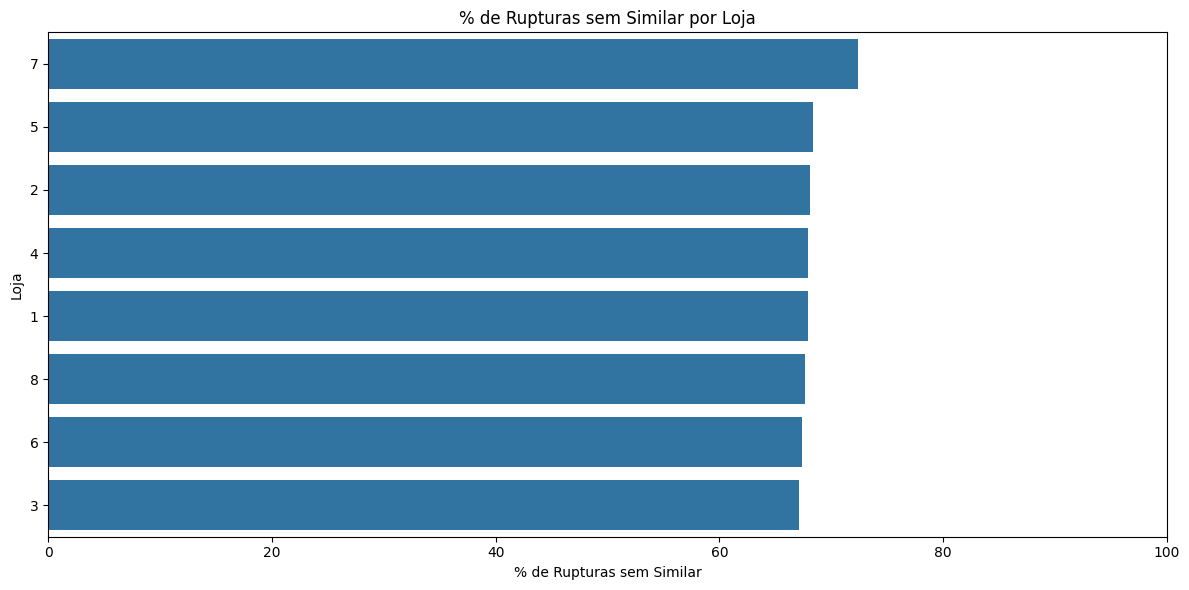

In [50]:
plt.figure(figsize=(12, 6))
sns.barplot(data=rupturas_com_proporcao.sort_values('perc_sem_similar', ascending=False),
            x='perc_sem_similar', y='key_loja')
plt.title('% de Rupturas sem Similar por Loja')
plt.xlabel('% de Rupturas sem Similar')
plt.ylabel('Loja')
plt.xlim(0, 100)
plt.tight_layout()
plt.show()

Vou plotar esses gráficos em uma visão no tempo para entender se tem relação com sazionalidade